# Deep Learning Uncertainty Quantification Methods Comparison



The aim of this notebook is to compare the performance of different uncertainty quantification (UQ) methods. The notebook include three sections:

1. Deteministic neural network prediction in region without observation
2. Uncertaninty quantification methods comparison
3. Gaussian process


We will run a simulated experiment following the approch of the paper "[A Brief Tour of Deep Learning from a Statistical Perspective](https://doi.org/10.1146/annurev-statistics-032921-013738)", where an unknown *true function* must be estimated from N observations.  The observations are available in two regions of the unknown function domain, and there is some noise added in their measurement. The model was trained on the observations, but it is also fed with input from regions without observations during the inference phase.

Inspired by lectures and code from UVA DEEP LEARNING COURSE

https://uvadlc.github.io/

https://github.com/phlippe/uvadlc_notebooks

# Experiment Setup



-------------------------------------------------

Import standard libraries and setting random seeds for reproducibility.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(45)
np.random.seed(45)

## Syntetic Data

Let's simulate an unknonw "true" function and some observations in separated regions.
Note that there are several regions without observations and that we are going to add some random mesurement noise to the observations.

In [2]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

    return x_train, y_train

In [3]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()
    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)



    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

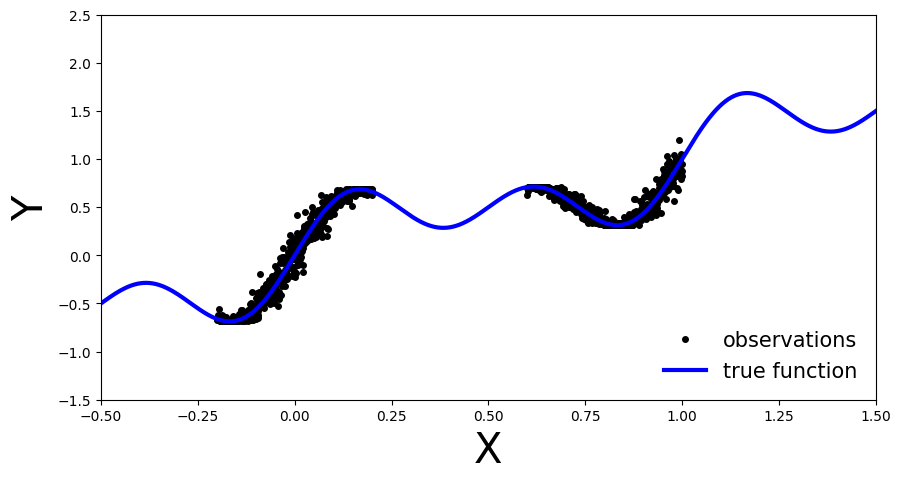

In [4]:
plot_generic()

We have the true function in blue. The observations are available in two regions of the function domain and there is some noise in their measurement.

##  Neural network reference architecture

First let's create a standard fully connected MLP neural network (NN). This NN will produce our single point estimate.
We will define a class with parametric number of hidden layers so so we can reuse the same class for different NN.

The *use_dropout* flag,  allow us to easily reuse the same class also for dropout method simulation.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

# Deteministic neural network prediction in region without observations

Now we will train our MLP on sytetic data generated above using standard ADAM fitting strategy.

In [6]:
losses=[]
def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().item())
    return net

In [7]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, train_data)
y_preds = net(x_test).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

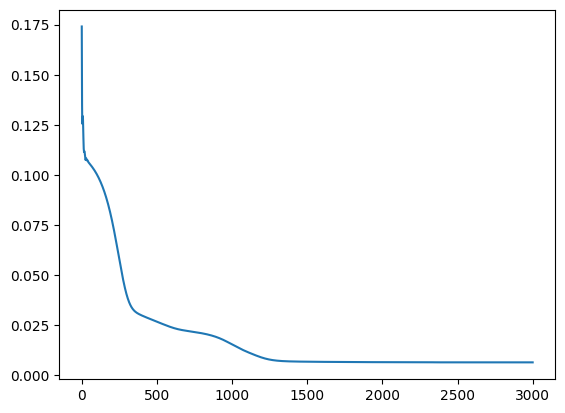

In [8]:
plt.plot(losses)

## Deterministic NN predictions

Let's investigate how our deterministic MLP generalizes over the entire domain of our input variable $x$.  The model was only trained on the observations but we will ask predictions for input in regions without training data.

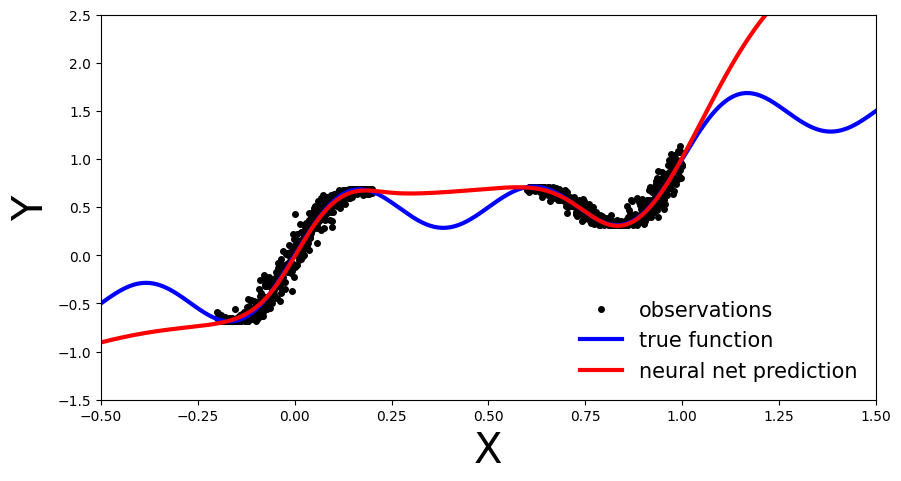

In [9]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'r-', linewidth=3, label='neural net prediction')

    plot_generic(add_predictions)
plot_predictions(x_test, y_preds)

We can see that our deterministic MLP (red line) has correctly learned the data distribution in the training regions, however, as the model has not learned the underlying sinusoidal wave function, it's predictions outside the training region are inaccurate. Moreoever, as our MLP is a single point estimate NN, we have no measure confidence for the predictions.

# Uncertaninty quantification methods comparison

In this section we will explore several uncertaonty quantification methods.

### Deep Ensemble

Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, *an ensemble*, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$
where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

### Deep Ensamble Training

We will reuse the MLP architecture introduced before, simply now we will train an ensemble of such models

In [10]:
ensemble_size = 5
ensemble = [MLP(hidden_dim=10, n_hidden_layers=5) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Same as before, let's investigate how our Deep Ensemble performs on the entire data domain of our input variable $x$.

In [11]:
y_preds = [np.array(net(x_test).clone().detach().numpy()) for net in ensemble]

Plot each ensemble member's predictive function.

In [12]:
def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

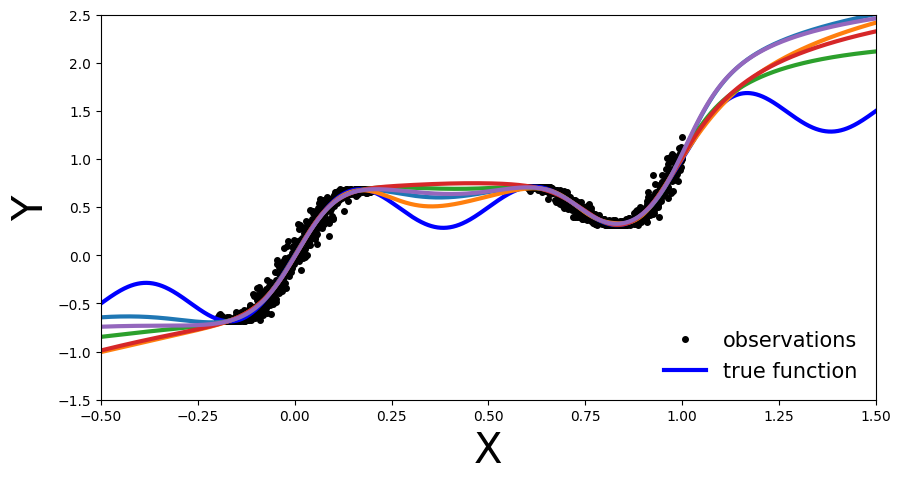

In [13]:
plot_multiple_predictions(x_test, y_preds)

In this plot the benefit of an ensemble approach is not immediately clear. Still on the regions outside the training data each of the trained NN is inaccurate. So what is the benefit you might ask.

Well let's plot the above in a slightly different way: let's visualize the ensemble's **uncertainty bands**.
> From a Bayesian perspective we want to quantify the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$

> In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.


In [14]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

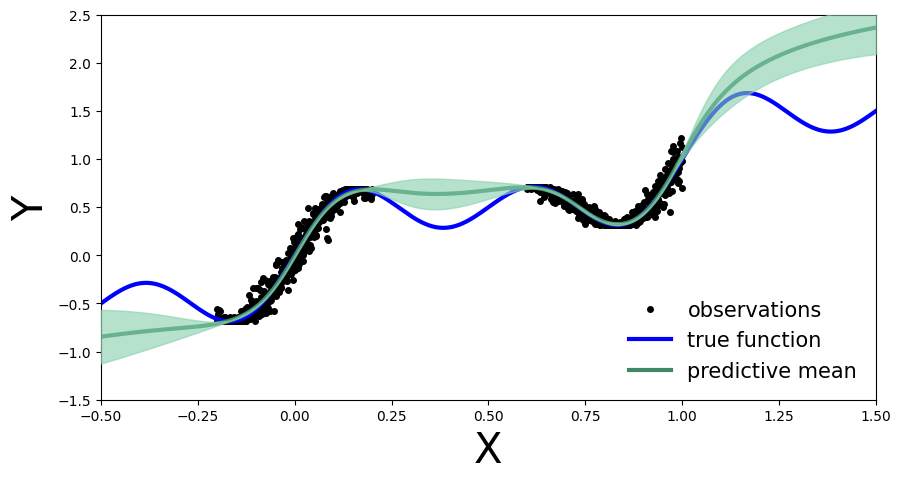

In [15]:
plot_uncertainty_bands(x_test, y_preds)

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model's uncertainty about its prediction.

### Monte Carlo Dropout

First we create our MC-Dropout Network. As you can see in the code below, creating a dropout network is extremely simple:
We can reuse our existing network architecture, the only alteration is that during the forward pass we randomly *switch off* (zero) some of the elements of the input tensor.

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution $\theta_{i} ∼ q(\theta|D)$.


**Training**

In [16]:
net_dropout = MLP(hidden_dim=10, n_hidden_layers=5, use_dropout=True)
net_dropout = train(net_dropout, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Similarly to Deep Ensembles, we pass the test data multiple times through the MC-Dropout network. We do so to obtain $y_{i}$ at the different parameter settings, $\theta_{i}$ of the network, $y_{i}=f(x,\theta_{i})$, governed by the dropout mask.

>This is the main difference compared to dropout implementation in a deterministic NN where it serves as a regularization term. In normal dropout application during test time the dropout is **not** applied. Meaning that all connections are present, but the weights are [adjusted](https://cs231n.github.io/neural-networks-2/)

In [17]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
y_preds = np.array(y_preds)

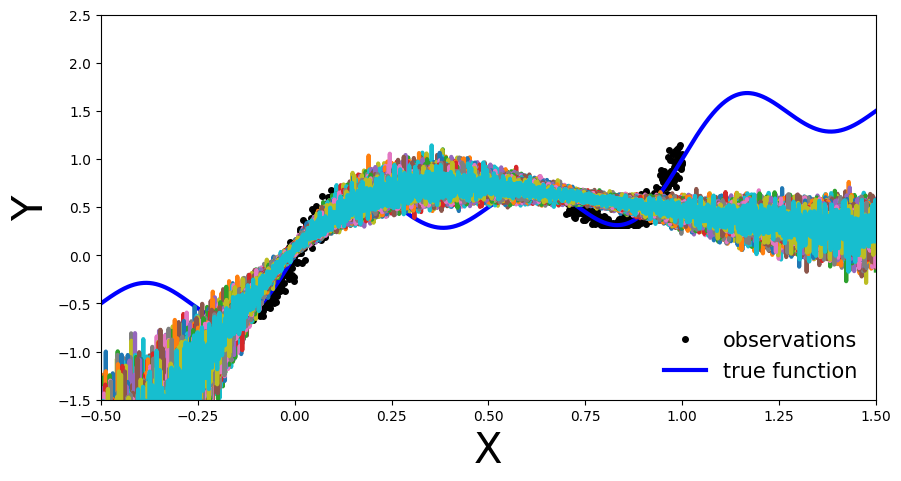

In [18]:
plot_multiple_predictions(x_test, y_preds)

In the above plot each colored line (apart from blue) represents a different parametrization, $\theta_{i}$, of our MC-Dropout Network.

Likewise to the Deep Ensemble Network, we can also compute the MC-dropout's **uncertainty bands**.

> The approach in practice is the same as before: we compute the mean and standard deviation across each dropout mask, which corresponds to the marginal estimation we discussed earlier.

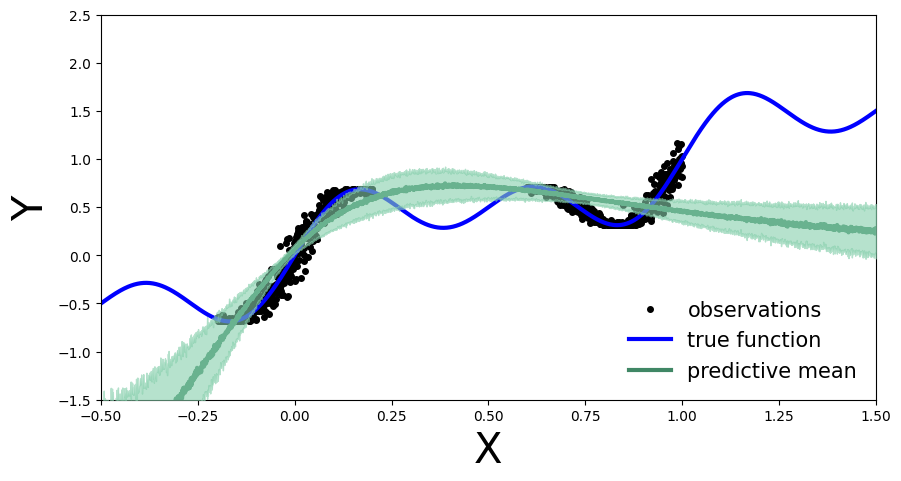

In [19]:
plot_uncertainty_bands(x_test, y_preds)

In the same way as Deep Ensembles, MC-Dropout allows us to have an uncertainty estimate next to our point wise predictions. However, for the given use-case this has come with the cost of an overall drop in the model's performance on the training regions. We observe this because at every pass through our network we randomly choose which nodes to keep, so one could argue that we hinder the networks optimal performance.

### Conformal prediction

Conformal prediction is a statistical uncertainty quantification approach that has gained interest in the Machine Learning community more recently. Originally proposed by [Vovk et al.](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf), it allows us to construct statistically rigorous uncertainty bands around our predictions, without requiring any modifications to our prediction model. This is achieved by comparing true and predicted values on out-of-sample data (more precisely we are looking at _inductive_ conformal prediction), and computing an empirical quantile $\hat{q}$ based on these comparisons that defines the magnitude of the uncertainy bands. How we compare true and predicted values is a modelling decision, and there are different ways to do so. The comparison results are also called _(non)conformity scores_, hence the naming of the method.

If we follow the conformal recipe, with minimal assumptions our uncertainty bands will be statistically rigorous in the sense that they satisfy a nice property for any test sample $(X_{n+1},Y_{n+1})$:

$$ \mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha,$$ i.e. with probability at least $1-\alpha$, our computed uncertainty band $\hat{C}(X_{n+1})$ around our point estimate $\hat{Y}_{n+1}$ will contain the _true_ unknown value $Y_{n+1}$. This is called a (marginal) coverage guarantee, and provides us with a measure of confidence in the quality of our uncertainty bands.

We will now see that the implementation of conformal prediction for our example is in fact very simple, which is part of its attractiveness.

**Training**

Firstly, we split our training samples into two different data sets, the true training set and a hold-out data set, which we call the calibration set (you can think of it as a specific kind of validation set). We will take 20% of our data for calibration. Usually this is a random sample, but for reproducebility we select them evenly spaced.

In [20]:
# split data into training and calibration sets
x, y = get_simple_data_train()
cal_idx = np.arange(len(x), step=1/0.2, dtype=np.int64)
# cal_idx = np.random.choice(len(x), size=int(len(x) * 0.2), replace=False) # random selection
mask = np.zeros(len(x), dtype=bool)
mask[cal_idx] = True
x_cal, y_cal = x[mask], y[mask]
x_train, y_train = x[~mask], y[~mask]

 Then, we train a single standard (non-Bayesian) MLP on the true training set:

In [21]:
net = MLP(hidden_dim=10, n_hidden_layers=5)
net = train(net, (x_train, y_train))

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Same as before, we first visualize how the MLP performs on the entire data domain of our input variable $x$. We see that training it on only 80% instead of all available data did not notably change its performance.

In [22]:
# compute predictions everywhere
x_test = torch.linspace(-.5, 1.5, 1000)[:, None]
y_preds = net(x_test).clone().detach().numpy()

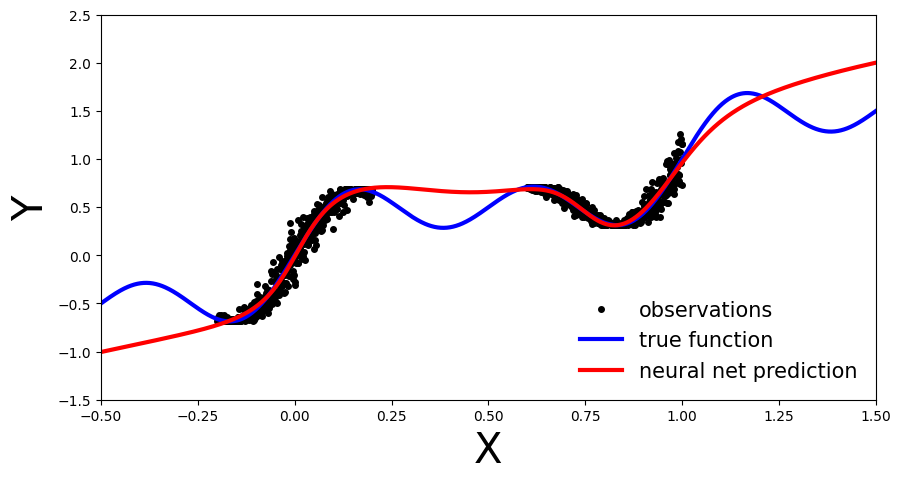

In [23]:
plot_predictions(x_test, y_preds)

We now perform the conformal prediction procedure to obtain our uncertainty bands. In the simplest case, our comparison of predicted and true values on the calibration data is achieved by simply looking at the residuals $|y-\hat{y}|$, which form our _conformity scores_. We then compute $\hat{q}$ as the $\left\lceil \frac{(n+1)(1-\alpha)}{n} \right\rceil$ empirical quantile of these residuals, and form our uncertainty bands for every test sample as $\hat{C}(X_{n+1})=[\hat{f}(x_{n+1})-\hat{q},\, \hat{f}(x_{n+1}) +\hat{q}].$ Our desired coverage rate is $(1-\alpha) \in [0,1]$, which we set to 90% (i.e. choose $\alpha=0.1$).


In [24]:
# compute calibration residuals
y_cal_preds = net(x_cal).clone().detach()
resid = torch.abs(y_cal - y_cal_preds).numpy()

In [25]:
# compute conformal quantile
alpha = 0.1
n = len(x_cal)
q_val = np.ceil((1 - alpha) * (n + 1)) / n
q = np.quantile(resid, q_val, method="higher")

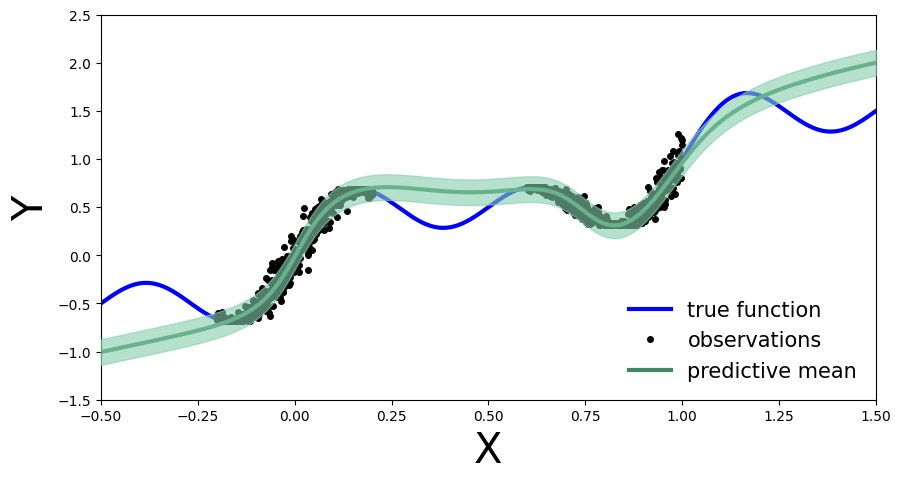

In [26]:
# true function
x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# generate plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")
ax.plot(x_test, y_preds, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_preds - q, y_preds + q, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False);

We now obtain an uncertainty band around each test set prediction, which is informed by our performance on the calibration data (as quantified by the residuals). We can also compare our empirical coverage on the available test data against our target coverage of 90%:

In [27]:
# compute empirical coverage across whole test domain
cov = np.mean(((y_preds - q) <= y_true) * ((y_preds + q) >= y_true))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 54.900000%


We notice that the empirical coverage does not match our target coverage, suggesting that the conformal procedure is not working well for our given test samples (we are under-covering). This is mainly due to the fact that our calibration data, which is selected from available observations, is very localized and therefore not representative of the whole test domain. In other words, the information we get from the calibration data does not translate well to the whole test domain. Therefore the computed quantile $\hat{q}$ is inadequate on unseen sample spaces. Compare this to our empirical coverage for test samples from the domain of our calibration data:


In [28]:
# compute empirical coverage only on previously observed test domain
mask = (x_true >= -.2) * (x_true < 0.2) + (x_true >= .6) * (x_true < 1)
cov = np.mean(((y_preds[mask] - q) <= y_true[mask]) * ((y_preds[mask] + q) >= y_true[mask]))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 100.000000%


Here we are in fact over-covering, i.e. being overly conservative in the magnitude of our uncertainty bands. Note that the coverage guarantee only holds _marginally_, i.e. across _all possible_ sets of calibration and test samples; this is particularly obvious in our case. Other factors playing a role in obtaining useful uncertainty bands are the choice of $\alpha$, size of the calibration set and the predictive model's performance.

# Gaussian Process


In [29]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

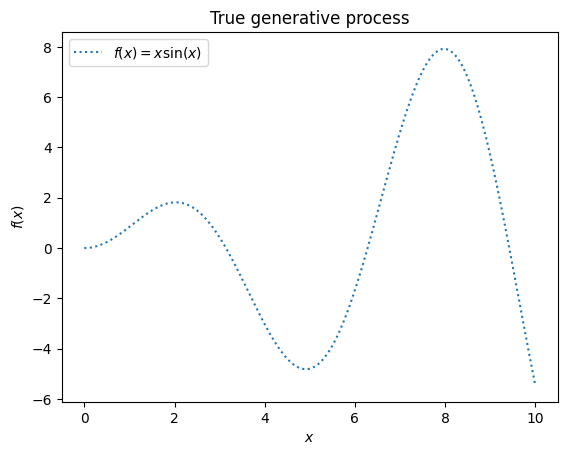

In [30]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [31]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [32]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

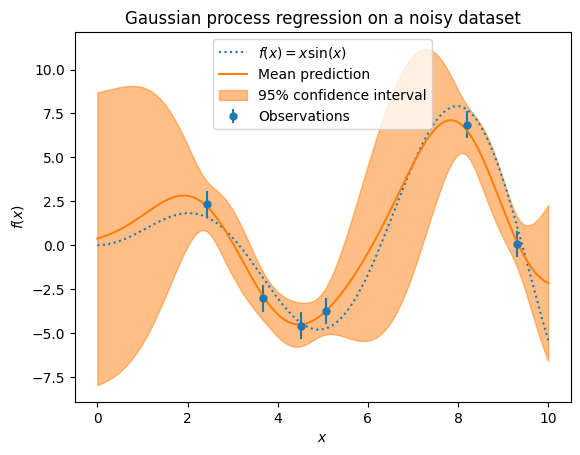

In [34]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

### Gaussian Process in regions without observations

In [35]:
x = np.linspace(-.2, 0.2, 500)
x_train = np.hstack([x, np.linspace(.6, 1, 500)])
eps = 0.02 * np.random.randn(x_train.shape[0])
y_train = x_train + 0.3 * np.sin(2 * np.pi * (x_train + eps)) + 0.3 * np.sin(4 * np.pi * (x_train + eps)) + eps
x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,)
x_train,y_train = get_simple_data_train()
gaussian_process.fit(x_train, y_train)
gaussian_process.kernel_

0.328**2 * RBF(length_scale=0.0122)

In [37]:
mean_prediction, std_prediction = gaussian_process.predict(x_true.reshape(-1, 1), return_std=True)

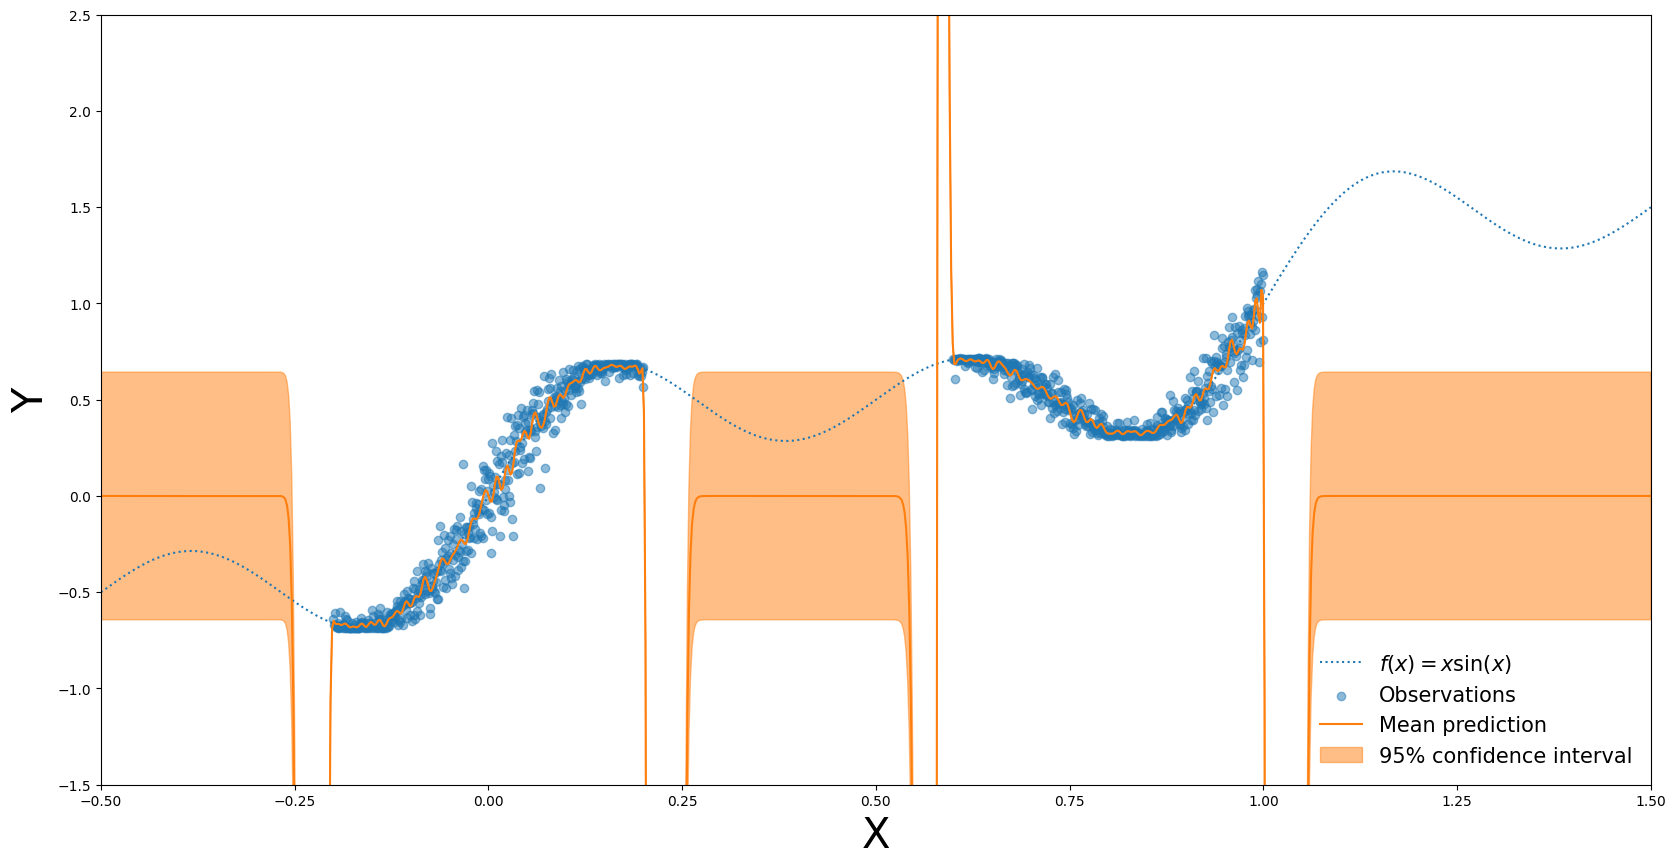

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x_true, y_true, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
ax.scatter(x_train, y_train, label="Observations",alpha=0.5)
ax.plot(x_true, mean_prediction, label="Mean prediction")
plt.fill_between(
    x_true.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    color="tab:orange",
    label=r"95% confidence interval",
)
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)
plt.legend(loc=4, fontsize=15, frameon=False)